# Amazon Review Sentiment Analysis

# Import Library

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re
import string
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
#
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, GlobalAveragePooling1D, Conv1D, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2



In [24]:
# membaca dataset
df_reviews = pd.read_csv('amazon.csv')

In [25]:
# informasi umum dataset
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19996 entries, 0 to 19995
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    19996 non-null  object
 1   label   19996 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [26]:
# menghitung missing value
df_reviews.isna().value_counts()

Text   label
False  False    19996
Name: count, dtype: int64

In [27]:
# memeriksa duplikat
df_reviews.duplicated().sum()

0

In [28]:
# menampilkan 5 baris pertama dataset
df_reviews.head()

,Text,label
0,This is the best apps acording to a bunch of ...,1
1,This is a pretty good version of the game for ...,1
2,this is a really . there are a bunch of levels...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1


# Distribusi Label 

Kita akan memeriksa hasil distribusi label dari dataset yang akan kita gunakan untuk membangun model sentimen.

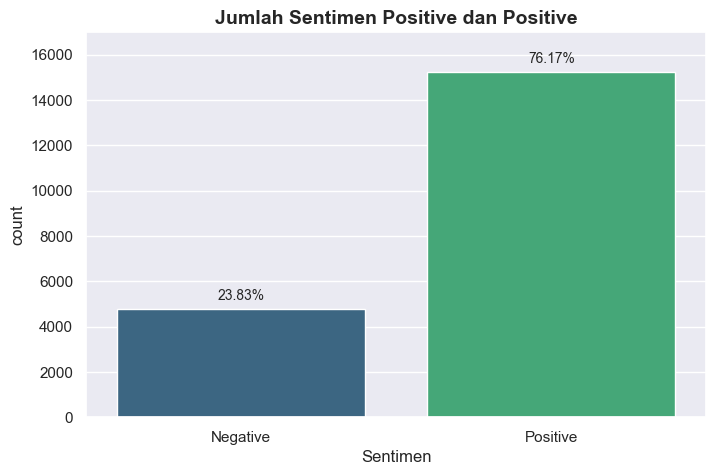

In [29]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(8,5))
ax = sns.countplot(data=df_reviews, x='label', palette='viridis')

for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / len(df_reviews) * 100:.2f}%',
                (bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='center', size=10, xytext=(0, 10),
                textcoords='offset points')
    
plt.title('Jumlah Sentimen Positive dan Positive', size=14, fontweight='bold')
plt.ylim(0, 17000)
plt.xlabel('Sentimen')
plt.xticks(ticks=[0,1], labels=['Negative','Positive'])
plt.show()

Pada keseluruhan data yang dimiliki mayoritas review pada e-commerce amazon adalah positive dimana bisa kita lihat bahwa komposisi dari sentimen negatif dan positif terlihat perbedaan yang cukup jauh, dimana untuk nilai sentimen negatif itu sebesar 5000 reviews dan untuk yang positif terdapat 15000 reviews.

# Text Pre-Processing

## Case Folding

Tahapan case folding merupakan proses dimana mengubah kalimat menjadi huruf kecil agar data kita tidak memiliki dua bentuk. Ex : 'Good', 'good'

In [30]:
df_reviews['text_case_folding'] = df_reviews.Text.str.lower()
df_reviews.head()

,Text,label,text_case_folding
0,This is the best apps acording to a bunch of ...,1,this is the best apps acording to a bunch of ...
1,This is a pretty good version of the game for ...,1,this is a pretty good version of the game for ...
2,this is a really . there are a bunch of levels...,1,this is a really . there are a bunch of levels...
3,"This is a silly game and can be frustrating, b...",1,"this is a silly game and can be frustrating, b..."
4,This is a terrific game on any pad. Hrs of fun...,1,this is a terrific game on any pad. hrs of fun...


## Cleaning Data

Pada tahap cleaning data merupakan proses dimana membersihkan karakter-karakter seperti tanda baca, simbol, angka, html, mention dan lain-lain.

In [31]:
# fungsi-fungsi yang digunakan untuk cleaning sentences
def remove_urls(text): # fungsi untuk menghapus url 
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_hastagh(text): # fungsi untuk menghapus hastag
    hastag_pattern = re.compile(r'#\S+')
    return hastag_pattern.sub(r'', text)

def remove_mention(text): # fungsi untuk menghapus mention
    mention_pattern = re.compile(r'@\S+')
    return mention_pattern.sub(r'', text)

def remove_emojis(text): # fungsi untuk menghapus emoticon
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_symbols(text): # fungsi untuk menghapus symbol-symbol
    return text.translate(str.maketrans('', '', string.punctuation))    
def remove_number(text): # fungsi untuk menghapus angka
    return text.translate(str.maketrans('', '', string.digits))
def reduce_repeated_characters(text): # fungsi untuk menghapus huruf berulang
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

# apply semua fungsi 
def preprocess_sentence(text):
    text = remove_urls(text)
    text = remove_hastagh(text)
    text = remove_mention(text)
    text = remove_emojis(text)
    text = remove_symbols(text)
    text = remove_number(text)
    text = reduce_repeated_characters(text)
    return text


In [32]:
# contoh uji coba
text = "Hey @user, check out the webpage: https://example.com. I found it awesome! 😎 #exciting 000123 aaaweesssooooommme" # @param {text: "string"}
print(preprocess_sentence(text))

Hey  check out the webpage  I found it awesome  aaweessoomme


In [33]:
# mengaplikasikan fungsi ke text
df_reviews['text_cleaning'] = df_reviews.text_case_folding.apply(preprocess_sentence)
df_reviews.drop('label', axis=1).tail()

,Text,text_case_folding,text_cleaning
19991,this app is fricken stupid.it froze on the kin...,this app is fricken stupid.it froze on the kin...,this app is fricken stupidit froze on the kind...
19992,Please add me!!!!! I need neighbors! Ginger101...,please add me!!!!! i need neighbors! ginger101...,please add me i need neighbors ginger thanks b...
19993,love it! this game. is awesome. wish it had m...,love it! this game. is awesome. wish it had m...,love it this game is awesome wish it had more...
19994,I love love love this app on my side of fashio...,i love love love this app on my side of fashio...,i love love love this app on my side of fashio...
19995,This game is a rip off. Here is a list of thin...,this game is a rip off. here is a list of thin...,this game is a rip off here is a list of thing...


## Lemmatization

In [34]:
# fungsi yang digunakan untuk lematization text
def lemmatize_nltk(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmas)

In [35]:
# mengaplikasikan fungsi ke text
df_reviews['text_lemma'] = df_reviews.text_cleaning.apply(lemmatize_nltk)
df_reviews.drop('label', axis=1).head()

,Text,text_case_folding,text_cleaning,text_lemma
0,This is the best apps acording to a bunch of ...,this is the best apps acording to a bunch of ...,this is the best apps acording to a bunch of ...,this is the best apps acording to a bunch of p...
1,This is a pretty good version of the game for ...,this is a pretty good version of the game for ...,this is a pretty good version of the game for ...,this is a pretty good version of the game for ...
2,this is a really . there are a bunch of levels...,this is a really . there are a bunch of levels...,this is a really there are a bunch of levels ...,this is a really there are a bunch of level an...
3,"This is a silly game and can be frustrating, b...","this is a silly game and can be frustrating, b...",this is a silly game and can be frustrating bu...,this is a silly game and can be frustrating bu...
4,This is a terrific game on any pad. Hrs of fun...,this is a terrific game on any pad. hrs of fun...,this is a terrific game on any pad hrs of fun ...,this is a terrific game on any pad hr of fun m...


# Membagi Features dan Target


In [36]:
# membagi features dan target
features = df_reviews.text_lemma
target = df_reviews.label

# Membangun Model Machine Learning

## Feature Extraction

In [37]:
# text pre-processing dengan NLTK
stop_words = list(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

In [38]:
# apply tf idf dan menghapus stopword 
features_tfidf = count_tf_idf.fit_transform(features)

In [39]:
data_tf_idf = pd.DataFrame(features_tfidf.toarray(), columns=count_tf_idf.get_feature_names_out())
data_tf_idf

,aa,aac,aagloorp,aah,aahowever,aaliyah,aammazinng,aapp,aardvark,aarp,...,zomg,zone,zoo,zoology,zoom,zoomed,zooming,zpg,zumocast,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# ukuran features
features_tfidf.shape

(19996, 20880)

## Resampling dengan SMOTE

Karena terdapat imbalance class pada dataset, maka kita akan melakukan teknik resampling menggunakan SMOTE. dimana teknik tersebut melakukan resampling kelas minoritas agar banyaknya menjadi sama dengan kelas mayoritas.

In [41]:
# Menerapkan SMOTE untuk oversampling
smote = SMOTE(random_state=404)

X_resampled, y_resampled = smote.fit_resample(features_tfidf, target)

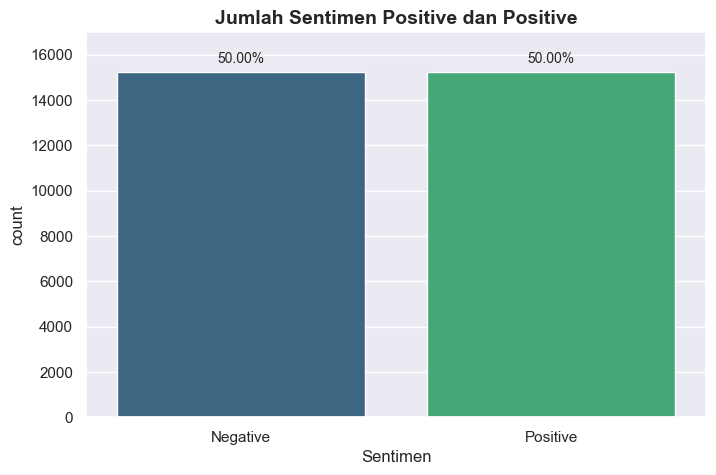

In [42]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(8,5))
ax = sns.countplot(x=y_resampled,  palette='viridis')

for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / len(y_resampled) * 100:.2f}%',
                (bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='center', size=10, xytext=(0, 10),
                textcoords='offset points')
    
plt.title('Jumlah Sentimen Positive dan Positive', size=14, fontweight='bold')
plt.ylim(0, 17000)
plt.xlabel('Sentimen')
plt.xticks(ticks=[0,1], labels=['Negative','Positive'])
plt.show()

## Splitting Data

In [43]:
# splitting data 75:25
features_train_ml, features_test_ml, target_train_ml, target_test_ml = train_test_split(X_resampled, y_resampled, random_state=404, test_size=0.25)

## Modeling

In [44]:
nb = MultinomialNB()

nb.fit(features_train_ml, target_train_ml)

target_pred = nb.predict(features_test_ml)
print(classification_report(target_test_ml, target_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      3775
           1       0.90      0.89      0.90      3840

    accuracy                           0.90      7615
   macro avg       0.90      0.90      0.90      7615
weighted avg       0.90      0.90      0.90      7615



Dengan menggunakan model machine learning dengan algoritma Multinomial Naive Bayes kita mendapatkan nilai akurasi untuk sentimen analisis amazon review sebesar 90% dan presisi recall juga diangka 90%. Selanjutnya kita akan mencoba membuat model dengan neural network


# Membangun Model Neural Network

In [45]:
# menghitung jumlah kata dan kalimat
all_words = [word for tokens in features.str.split() for word in tokens]
sentence_lengths = [len(tokens) for tokens in features]
VOCAB = sorted(list(set(all_words)))
print(f"jumlah total kata = {len(all_words)}, dengan ukuran vocabulary = {len(VOCAB)}")
print(f"Panjang maksimum kalimat adalah {max(sentence_lengths)}")

jumlah total kata = 672842, dengan ukuran vocabulary = 21032
Panjang maksimum kalimat adalah 254


## Tokenizer

In [50]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 254
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(features.values)
word_index = tokenizer.word_index
print(f'Jumlah token unik: {len(word_index)}')

Jumlah token unik: 21032


In [56]:
X = tokenizer.texts_to_sequences(features.values)
# padding
X_padded = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print(f'Ukuran data tensor: {X_padded.shape}')

Ukuran data tensor: (19996, 254)


## SMOTE

In [59]:
X_resampled_nn, y_resampled_nn = smote.fit_resample(X_padded, target)
print(f'Ukuran setelah smote: {X_resampled_nn.shape}')

Ukuran setelah smote: (30460, 254)


In [132]:
# fungsi untuk encoding OHE pada label
def oneHotEncode(listArray):
  s = (len(listArray),len(np.unique(listArray)))
  tempData = np.zeros(s)
  for i in range(len(listArray)):
    if listArray[i] == 1:
      tempData[i][1] = 1
    elif listArray[i] == 0:
      tempData[i][0] = 1
  return tempData

# OHE untuk label/target
Y = oneHotEncode(y_resampled_nn)
Y.shape

(30460, 2)

## Splitting Data

In [144]:
# splitting data 75:25
features_train_nn, features_test_nn, target_train_nn, target_test_nn = train_test_split(X_resampled_nn, Y, 
                                                                                         random_state=404, 
                                                                                         test_size=0.25)

## Modeling LSTM

In [134]:
# fungsi yang digunakan untuk menghitung f1_score
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
    tf.keras.metrics.TruePositives(name='TP'),
    tf.keras.metrics.FalsePositives(name='FP'),
    tf.keras.metrics.TrueNegatives(name='TN'),
    tf.keras.metrics.FalseNegatives(name='FN'),
    tf.keras.metrics.CategoricalAccuracy(name='Acc'),
    tf.keras.metrics.Precision(name='Precision'),
    tf.keras.metrics.Recall(name='Recall'),
    tf.keras.metrics.AUC(name='ROC-AUC'),
    get_f1
]

In [135]:
# membangun model
model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=features_train_nn.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)


In [136]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_10            │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [137]:
# epoch sebanyak 20 kali
num_epochs = 20
batch_size = 32

model_hist = model.fit(features_train_nn, target_train_nn,
                       epochs=num_epochs, validation_split=0.1,
                       batch_size=batch_size,
                       verbose=2)

Epoch 1/20
643/643 - 76s - 118ms/step - Acc: 0.7653 - FN: 4825.0000 - FP: 4825.0000 - Precision: 0.7653 - ROC-AUC: 0.8433 - Recall: 0.7653 - TN: 15735.0000 - TP: 15735.0000 - get_f1: 0.7652 - loss: 0.4917 - val_Acc: 0.8053 - val_FN: 445.0000 - val_FP: 445.0000 - val_Precision: 0.8053 - val_ROC-AUC: 0.8860 - val_Recall: 0.8053 - val_TN: 1840.0000 - val_TP: 1840.0000 - val_get_f1: 0.8037 - val_loss: 0.4279
Epoch 2/20
643/643 - 79s - 123ms/step - Acc: 0.8602 - FN: 2874.0000 - FP: 2874.0000 - Precision: 0.8602 - ROC-AUC: 0.9338 - Recall: 0.8602 - TN: 17686.0000 - TP: 17686.0000 - get_f1: 0.8602 - loss: 0.3286 - val_Acc: 0.8477 - val_FN: 348.0000 - val_FP: 348.0000 - val_Precision: 0.8477 - val_ROC-AUC: 0.9197 - val_Recall: 0.8477 - val_TN: 1937.0000 - val_TP: 1937.0000 - val_get_f1: 0.8471 - val_loss: 0.3616
Epoch 3/20
643/643 - 73s - 114ms/step - Acc: 0.9143 - FN: 1762.0000 - FP: 1762.0000 - Precision: 0.9143 - ROC-AUC: 0.9720 - Recall: 0.9143 - TN: 18798.0000 - TP: 18798.0000 - get_f1: 0

## Evaluasi Data Training

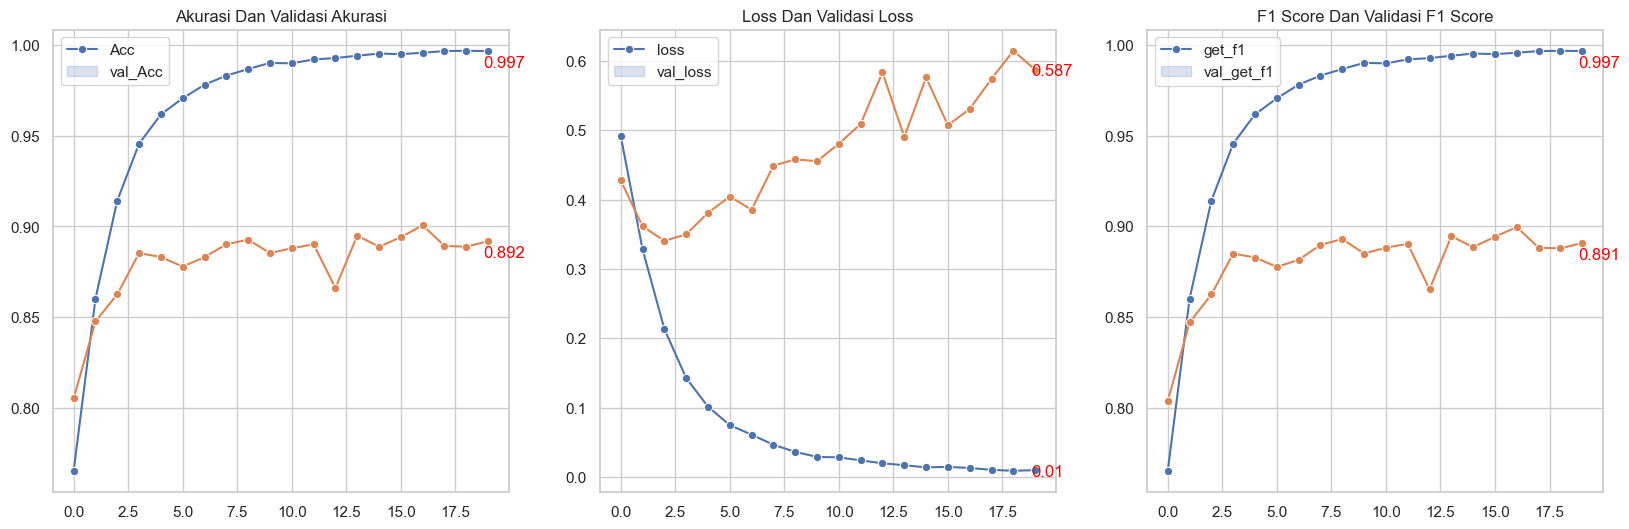

In [147]:
sns.set_style(style='whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(20,6))
graph = ['Acc', 'loss', 'get_f1']
title = ["Akurasi Dan Validasi Akurasi", "Loss Dan Validasi Loss", "F1 Score Dan Validasi F1 Score"]

def draw_graph(i, text, title):
    axes[i].set_title(title)
    fig = sns.lineplot(ax=axes[i], x=model_hist.epoch, y=model_hist.history[text], marker='o')
    fig = sns.lineplot(ax=axes[i], x=model_hist.epoch, y=model_hist.history[f'val_{text}'], marker='o')
    axes[i].legend([text, f'val_{text}'])

def text_graph(i, text):
    for j, (x, y) in enumerate(zip(model_hist.epoch, model_hist.history[f'{text}'])):
        if j == 19:
          axes[i].text(x = x - 0.2, y = y - 0.009, s = round(y, 3), color = 'red') 
    
    for j, (x, y) in enumerate(zip(model_hist.epoch, model_hist.history[f'val_{text}'])):
        if j == 19:
          axes[i].text(x = x - 0.2, y = y - 0.009, s = round(y, 3), color = 'red') 

for i, (val, tit) in enumerate(zip(graph, title)):
    draw_graph(i, val, tit)
    text_graph(i, val)

     


## Uji ke Data Testing

In [145]:
model_eval = model.evaluate(features_test_nn, target_test_nn, batch_size=32)
model_eval

238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - Acc: 0.8821 - FN: 459.8996 - FP: 459.8996 - Precision: 0.8821 - ROC-AUC: 0.9295 - Recall: 0.8821 - TN: 3379.9583 - TP: 3379.9583 - get_f1: 0.8821 - loss: 0.6209


[0.619820773601532,
 6703.0,
 912.0,
 6703.0,
 912.0,
 0.8802363872528076,
 0.8802363872528076,
 0.8802363872528076,
 0.9298495054244995,
 0.8802351355552673]

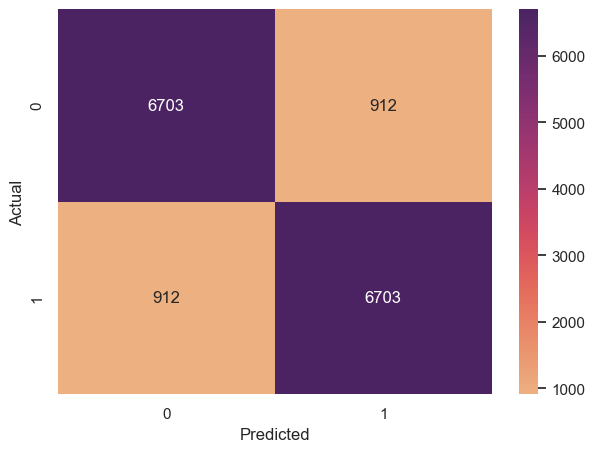

In [148]:
# confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap((
    [int(model_eval[1]), int(model_eval[2])],  
    [int(model_eval[2]), int(model_eval[1])]
), annot=True, xticklabels=[0, 1], yticklabels=[0, 1], cmap='flare', fmt='d')

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Kesimpulan

Dataset yang digunakan pada project ini merupakan data review tentang e-commerce yang bernama Amazon. Dataset ini merupakan data sekunder yang bisa di akses melalui *Kaggle.com* dengan 19996 baris data dan 2 kolom. Secara keseluruhan bisa dipastikan bahwa review customer terhadap platform amazon cenderung lebih banyak `Positif` berdasarkan hasil analisa yang telah dilakukan. 

Pada tahap selanjutnya adalah modeling dengan melakukan perbandingan menggunakan algoritma machine learning dan deep learning. Untuk machine learning kita menggunakan algoritma Multinomial Naive Bayes sedangkan untuk deep learning kita menggunakan LSTM-NN. Dikarenakan dataset ini memiliki data yang tidak seimbang pada label target, maka dilakukan teknik resampling untuk melakukan sintetik pada label minoritas. Kemudian setelah melakukan training pada kedua algoritma tersebut, hasilnya bisa dilihat ditabel berikut ini:

| Nama Model | Accuracy | Precision | Recall |
| --- | --- | --- | --- |
| Naive Bayes | 90% | 90% | 90% |
| LSTM-NN | 88.21% | 88.2% | 88.2% |

Berdasarkan tabel tersebut, kita bisa menyimpulkan model terbaik adalah dengan menggunakan algoritma machine learning Multinomial Naive Bayes